In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import scikitplot as skplt
import matplotlib.pyplot as plt
import mlflow
from time import time
from datetime import datetime

### Set MLflow

In [2]:
MLFLOW_SERVER = "http://127.0.0.1:5000"
mlflow.set_tracking_uri(MLFLOW_SERVER)

In [3]:
MLFLOW_EXPERIMENT_NAME = 'Lifestyle_Classification'
try:
    mlflow_exp_id = mlflow.create_experiment(name=MLFLOW_EXPERIMENT_NAME)
except Exception:
    mlflow_exp_id = mlflow.get_experiment_by_name(MLFLOW_EXPERIMENT_NAME).experiment_id # if already created

In [4]:
mlflow.sklearn.autolog(max_tuning_runs=None) # enable autologging

### Load Dataset

In [5]:
DF_PATH = "data/lifestyle_sustainability_data_standardized.csv"

In [6]:
df_raw = pd.read_csv(DF_PATH)
print(df_raw.shape)
print(df_raw.columns)
print(df_raw.dtypes)
df_raw.head()

(499, 13)
Index(['EnvironmentalAwareness', 'CommunityInvolvement',
       'MonthlyElectricityConsumption', 'MonthlyWaterConsumption',
       'PhysicalActivities', 'DietType_Balanced',
       'DietType_Mostly Animal-Based', 'DietType_Mostly Plant-Based',
       'TransportationMode_Bike', 'TransportationMode_Car',
       'TransportationMode_Public Transit', 'TransportationMode_Walk',
       'Rating'],
      dtype='object')
EnvironmentalAwareness               float64
CommunityInvolvement                 float64
MonthlyElectricityConsumption        float64
MonthlyWaterConsumption              float64
PhysicalActivities                   float64
DietType_Balanced                    float64
DietType_Mostly Animal-Based         float64
DietType_Mostly Plant-Based          float64
TransportationMode_Bike              float64
TransportationMode_Car               float64
TransportationMode_Public Transit    float64
TransportationMode_Walk              float64
Rating                             

,EnvironmentalAwareness,CommunityInvolvement,MonthlyElectricityConsumption,MonthlyWaterConsumption,PhysicalActivities,DietType_Balanced,DietType_Mostly Animal-Based,DietType_Mostly Plant-Based,TransportationMode_Bike,TransportationMode_Car,TransportationMode_Public Transit,TransportationMode_Walk,Rating
0,1.445313,1.385178,-1.594895,-1.340155,1.347737,-0.680693,-0.636894,1.238142,1.786974,-0.624477,-0.571951,-0.553428,5
1,0.699490,-0.034132,-0.348649,-0.114045,-0.062160,1.469091,-0.636894,-0.807662,-0.559605,-0.624477,1.748402,-0.553428,4
2,-0.792157,-1.453442,0.897597,1.112064,-1.472057,-0.680693,1.570120,-0.807662,-0.559605,1.601339,-0.571951,-0.553428,1
3,0.699490,-0.034132,-1.179480,-0.931452,1.347737,-0.680693,-0.636894,1.238142,-0.559605,-0.624477,-0.571951,1.806919,5
4,-0.046334,-1.453442,0.066766,0.294658,-0.062160,1.469091,-0.636894,-0.807662,-0.559605,-0.624477,1.748402,-0.553428,3


In [7]:
df_raw.groupby("Rating").size()

Rating
1     97
2     34
3    101
4     91
5    176
dtype: int64

#### Prepare X and Y

In [8]:
RANDOM_STATE = 42
test_size = 0.05 # test set
val_size = 0.1 # validation set

In [9]:
df = df_raw.copy()
df.shape

(499, 13)

In [10]:
df["Rating"] = df["Rating"].apply(lambda rating: rating - 1) # required to fit XGBoost
target_column = df.pop("Rating")
X = df.to_numpy()
Y = np.array(target_column.to_list())
X.shape, Y.shape

((499, 12), (499,))

Train/Test Split (Stratified Test)

In [11]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size, stratify=Y, random_state=RANDOM_STATE) # stratified train/test
print(f"X_train: {X_train.shape} | Y_train: {Y_train.shape}")
print(f"X_test: {X_test.shape} | Y_test: {Y_test.shape}")
print(f"Y_test label distribution: {np.unique(Y_test, return_counts=True)}")

X_train: (474, 12) | Y_train: (474,)
X_test: (25, 12) | Y_test: (25,)
Y_test label distribution: (array([0, 1, 2, 3, 4]), array([5, 2, 5, 4, 9], dtype=int64))


---

In [12]:
number_of_splits = 5

stratified_shufflesplit = StratifiedShuffleSplit(n_splits=number_of_splits, test_size=val_size, random_state=RANDOM_STATE)
stratified_shufflesplit

StratifiedShuffleSplit(n_splits=5, random_state=42, test_size=0.1,
            train_size=None)

In [13]:
score_metric = "roc_auc_ovo" # ROC-AUC One-vs-One Approach

In [14]:
def report_best_score(random_search: RandomizedSearchCV):
    print(f"Best Score: {round(random_search.best_score_, 2)}")
    print(f"Best Params: {random_search.best_params_}")

### Random Forest

In [15]:
rf_model = RandomForestClassifier()

In [16]:
rf_model_params = {
    'n_estimators': np.arange(50, 151), 
    "max_depth": np.arange(2, 7), 
    'max_features': np.arange(2, X.shape[1] + 1)
}

param_combinations_rf = 50

In [17]:
random_search_rf = RandomizedSearchCV(rf_model, param_distributions=rf_model_params, n_iter=param_combinations_rf, scoring=score_metric, n_jobs=-1, 
                                      cv=stratified_shufflesplit.split(X_train, Y_train), return_train_score=True, refit=True, verbose=6, random_state=RANDOM_STATE)

In [18]:
timestamp = datetime.fromtimestamp(time()).strftime("%Y-%m-%d_%H:%M:%S")

with mlflow.start_run(experiment_id=mlflow_exp_id, run_name=f"RandomForest_{timestamp}"):
    random_search_rf.fit(X_train, Y_train)
    mlflow.log_params(random_search_rf.best_params_)
    mlflow.log_metric("best_score", round(random_search_rf.best_score_, 2))
    for param, value in random_search_rf.best_params_.items():
        mlflow.log_metric(param, value)
    mlflow.sklearn.log_model(random_search_rf.best_estimator_, "best_model") # Log the best model artifact

Fitting 5 folds for each of 50 candidates, totalling 250 fits


2024/11/03 16:28:15 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: cannot pickle 'generator' object
2024/11/03 16:28:20 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/03 16:28:21 INFO mlflow.tracking._tracking_service.client: 🏃 View run RandomForest_2024-11-03_16:27:55 at: http://127.0.0.1:5000/#/experiments/319880400991676970/runs/7da80b092d2e4d77a619c4d21f68c44d.
2024/11/03 16:28:21 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/319880400991676970.


In [19]:
random_search_rf_results = pd.DataFrame(random_search_rf.cv_results_)
print(random_search_rf_results.shape)
random_search_rf_results.head()

(50, 23)


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_max_features,param_max_depth,params,split0_test_score,split1_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.328635,0.054669,0.035012,0.011590,102,10,2,"{'n_estimators': 102, 'max_features': 10, 'max...",0.833003,0.769230,...,0.829050,0.033778,48,0.861403,0.855819,0.867763,0.871117,0.858667,0.862954,0.005683
1,0.373426,0.032016,0.042187,0.009595,87,11,6,"{'n_estimators': 87, 'max_features': 11, 'max_...",0.885508,0.838609,...,0.869369,0.019327,24,0.992350,0.994584,0.993139,0.993044,0.992817,0.993186,0.000750
2,0.433992,0.082627,0.035718,0.013951,125,9,6,"{'n_estimators': 125, 'max_features': 9, 'max_...",0.893834,0.846019,...,0.876236,0.021136,13,0.992634,0.994355,0.992595,0.994069,0.993102,0.993351,0.000731
3,0.304837,0.067566,0.024957,0.007137,90,9,6,"{'n_estimators': 90, 'max_features': 9, 'max_d...",0.886180,0.857829,...,0.877237,0.015150,11,0.992612,0.994178,0.992690,0.992734,0.992064,0.992855,0.000704
4,0.284845,0.052345,0.034553,0.010330,85,6,5,"{'n_estimators': 85, 'max_features': 6, 'max_d...",0.892996,0.861481,...,0.878694,0.013896,8,0.974989,0.979056,0.976950,0.978659,0.978759,0.977683,0.001536


In [20]:
report_best_score(random_search_rf)

Best Score: 0.89
Best Params: {'n_estimators': 60, 'max_features': 3, 'max_depth': 6}


In [21]:
best_rf_model = random_search_rf.best_estimator_
best_rf_model

RandomForestClassifier(max_depth=6, max_features=3, n_estimators=60)

#### Results of Test Split

In [22]:
Y_test_predicted_proba_rf = best_rf_model.predict_proba(X_test)
len(Y_test_predicted_proba_rf), Y_test_predicted_proba_rf[:2]

(25,
 array([[0.03877492, 0.01139137, 0.04438476, 0.27516325, 0.6302857 ],
        [0.00383956, 0.00384143, 0.01726321, 0.12340285, 0.85165295]]))

c:\Users\kevin\.conda\envs\h_ls_project_env\Lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


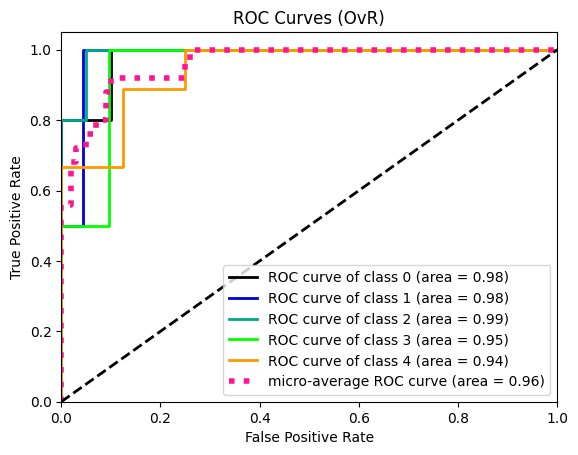

In [23]:
skplt.metrics.plot_roc_curve(Y_test, Y_test_predicted_proba_rf, title="ROC Curves (OvR)", curves=('micro', 'each_class')) # AUC-ROC OvR Approach
plt.show()

c:\Users\kevin\.conda\envs\h_ls_project_env\Lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_precision_recall instead.
  warnings.warn(msg, category=FutureWarning)


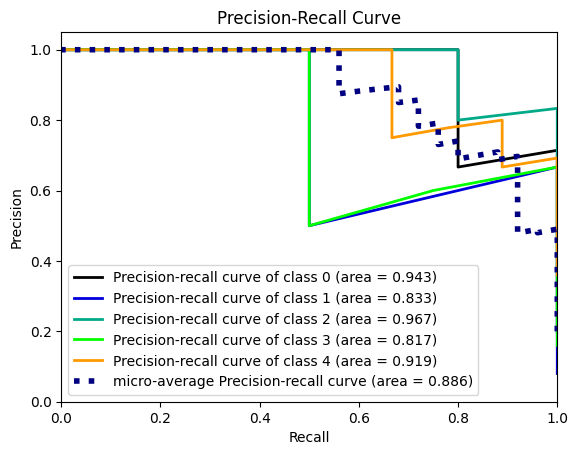

In [24]:
skplt.metrics.plot_precision_recall_curve(Y_test, Y_test_predicted_proba_rf)
plt.show()

### XGBoost

In [25]:
xgb_model = xgb.XGBClassifier(objective='multi:softprob') # XGBClassifier for multi-class classification

In [26]:
xgb_model_params = {
    "gamma": np.arange(0, 0.51, 0.01),
    "learning_rate": np.arange(0.01, 0.51, 0.01),
    "max_depth": np.arange(2, 7), 
    "n_estimators": np.arange(50, 151),
}

param_combinations_xgb = 50

In [27]:
random_search_xgb = RandomizedSearchCV(xgb_model, param_distributions=xgb_model_params, n_iter=param_combinations_xgb, scoring=score_metric, n_jobs=-1, 
                                       cv=stratified_shufflesplit.split(X_train, Y_train), return_train_score=True, refit=True, verbose=6, random_state=RANDOM_STATE)

In [28]:
timestamp = datetime.fromtimestamp(time()).strftime("%Y-%m-%d_%H:%M:%S")

with mlflow.start_run(experiment_id=mlflow_exp_id, run_name=f"XGBoost_{timestamp}"):
    random_search_xgb.fit(X_train, Y_train)
    mlflow.log_params(random_search_xgb.best_params_)
    mlflow.log_metric("best_score", round(random_search_xgb.best_score_, 2))
    for param, value in random_search_xgb.best_params_.items():
        mlflow.log_metric(param, value)
    mlflow.sklearn.log_model(random_search_xgb.best_estimator_, "best_model") # Log the best model artifact

Fitting 5 folds for each of 50 candidates, totalling 250 fits


2024/11/03 16:28:29 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: cannot pickle 'generator' object
2024/11/03 16:28:34 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/03 16:28:34 INFO mlflow.tracking._tracking_service.client: 🏃 View run XGBoost_2024-11-03_16:28:21 at: http://127.0.0.1:5000/#/experiments/319880400991676970/runs/c93f6e52be3440fca068a0fa6494179a.
2024/11/03 16:28:34 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/319880400991676970.


In [29]:
random_search_xgb_results = pd.DataFrame(random_search_xgb.cv_results_)
random_search_xgb_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_max_depth,param_learning_rate,param_gamma,params,split0_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.111872,0.018465,0.018382,0.005121,101,4,0.42,0.04,"{'n_estimators': 101, 'max_depth': 4, 'learnin...",0.862934,...,0.862627,0.018203,29,0.999742,0.999764,0.999618,0.999709,0.999627,0.999692,0.000059
1,0.063120,0.023741,0.014657,0.001999,60,2,0.30,0.26,"{'n_estimators': 60, 'max_depth': 2, 'learning...",0.904699,...,0.868976,0.026308,12,0.972051,0.971239,0.973591,0.974986,0.973350,0.973044,0.001297
2,0.103154,0.013346,0.024736,0.010750,76,3,0.12,0.05,"{'n_estimators': 76, 'max_depth': 3, 'learning...",0.891133,...,0.858630,0.027778,40,0.988032,0.990520,0.990103,0.989635,0.989706,0.989599,0.000845
3,0.087430,0.013395,0.018676,0.007216,62,3,0.14,0.10,"{'n_estimators': 62, 'max_depth': 3, 'learning...",0.890283,...,0.861476,0.025736,30,0.987164,0.990262,0.989926,0.989701,0.988845,0.989179,0.001111
4,0.174529,0.008415,0.027396,0.016054,127,3,0.19,0.04,"{'n_estimators': 127, 'max_depth': 3, 'learnin...",0.855657,...,0.846670,0.016079,48,0.999390,0.999141,0.998992,0.999540,0.999403,0.999293,0.000198


In [30]:
report_best_score(random_search_xgb)

Best Score: 0.88
Best Params: {'n_estimators': 80, 'max_depth': 5, 'learning_rate': 0.42000000000000004, 'gamma': 0.1}


In [31]:
best_xgb_model = random_search_xgb.best_estimator_

#### Results on Test Split

In [32]:
Y_test_predicted_proba_xgb = best_xgb_model.predict_proba(X_test)
len(Y_test_predicted_proba_xgb), Y_test_predicted_proba_xgb[:2]

(25,
 array([[0.00988441, 0.02894981, 0.01946027, 0.14397442, 0.79773104],
        [0.00141453, 0.00370531, 0.00278578, 0.05931138, 0.932783  ]],
       dtype=float32))

c:\Users\kevin\.conda\envs\h_ls_project_env\Lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


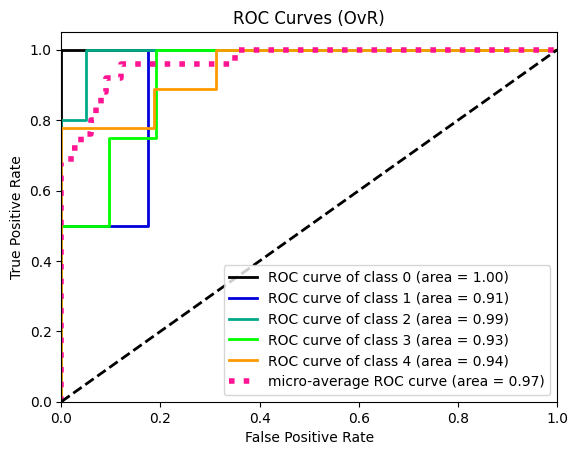

In [33]:
skplt.metrics.plot_roc_curve(Y_test, Y_test_predicted_proba_xgb, title="ROC Curves (OvR)", curves=('micro', 'each_class')) # AUC-ROC OvR Approach
plt.show()

c:\Users\kevin\.conda\envs\h_ls_project_env\Lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_precision_recall instead.
  warnings.warn(msg, category=FutureWarning)


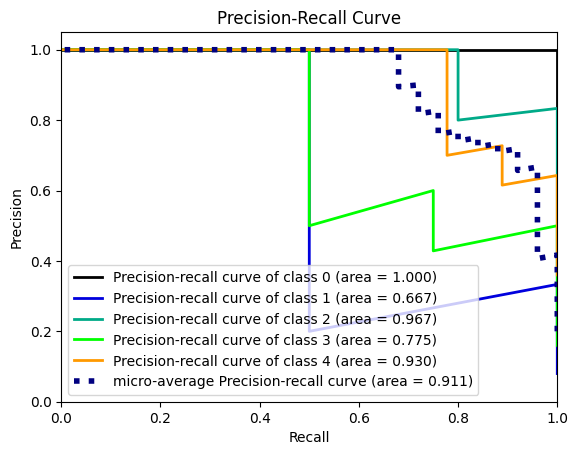

In [34]:
skplt.metrics.plot_precision_recall_curve(Y_test, Y_test_predicted_proba_xgb)
plt.show()

#### Feature Importance

In [35]:
for index, feature in enumerate(df.columns):
    print(f"f{index}: {feature}")

f0: EnvironmentalAwareness
f1: CommunityInvolvement
f2: MonthlyElectricityConsumption
f3: MonthlyWaterConsumption
f4: PhysicalActivities
f5: DietType_Balanced
f6: DietType_Mostly Animal-Based
f7: DietType_Mostly Plant-Based
f8: TransportationMode_Bike
f9: TransportationMode_Car
f10: TransportationMode_Public Transit
f11: TransportationMode_Walk


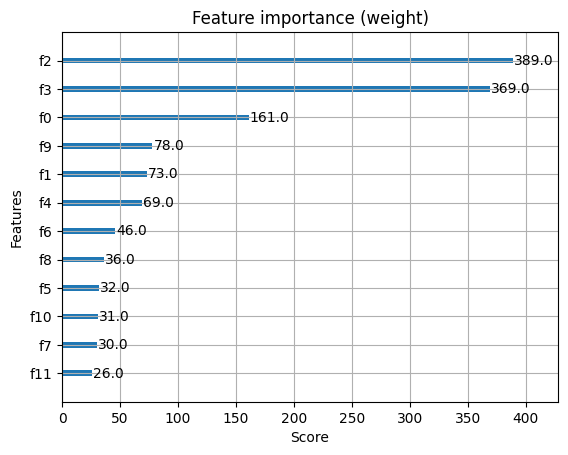

In [36]:
xgb.plot_importance(best_xgb_model, importance_type="weight", title="Feature importance (weight)", xlabel="Score")
plt.show()

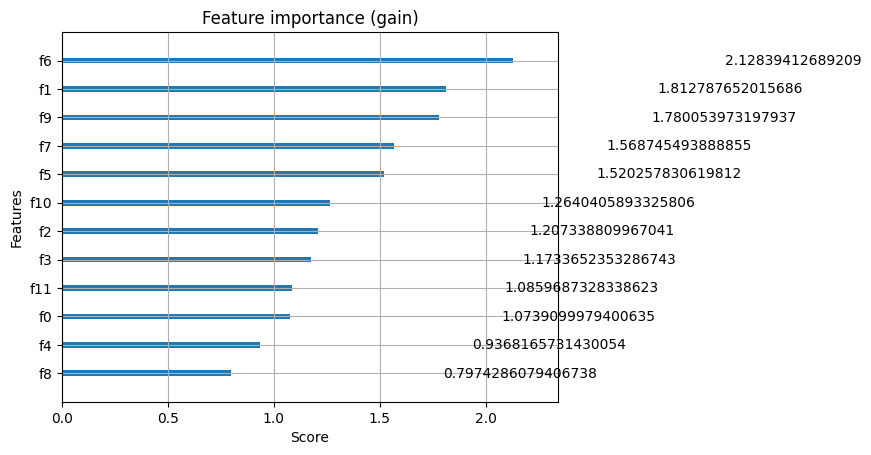

In [37]:
xgb.plot_importance(best_xgb_model, importance_type="gain", title="Feature importance (gain)", xlabel="Score")
plt.show()